# Gender and Age Prediction using ViTB/16

Automatic gender classification has been used in many applications. The goal of this project is to classify the gender of faces in an image. One can design a convolutional neural network or Transformer to achieve this goal. Some tasks to consider:

Modify some previously published architectures e.g., increase the network depth, reducing their parameters, etc. Explore more advanced techniques such as deformable convolution, dilated convolution (dilation>1) or visual prompt tuning for Transformers.
Consider age and gender recognition simultaneously to take advantage of the gender-specific age characteristics and age-specific gender characteristics inherent to images
Consider pre-training using the CelebA dataset http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

One of the main carachteristics of ViT is that the model has to be trained with an enourmous amount of data. The data should be of the order of 100 million. As we can not handle this amount of data we will use a pretrained ViT. The use of openAI has increased exponentially. ChatGPT is a weel know tool of the classifier. In this case we will use their zero-gradient classifiers.

In [1]:
! pip install ftfy regex tqdm;
! pip install git+https://github.com/openai/CLIP.git;

  Cloning https://github.com/openai/CLIP.git; to c:\users\jaime\appdata\local\temp\pip-req-build-8q8_2p0o


  Running command git clone --filter=blob:none --quiet 'https://github.com/openai/CLIP.git;' 'C:\Users\jaime\AppData\Local\Temp\pip-req-build-8q8_2p0o'
  remote: Repository not found.
  fatal: repository 'https://github.com/openai/CLIP.git;/' not found
  error: subprocess-exited-with-error
  
  git clone --filter=blob:none --quiet 'https://github.com/openai/CLIP.git;' 'C:\Users\jaime\AppData\Local\Temp\pip-req-build-8q8_2p0o' did not run successfully.
  exit code: 128
  
  See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

git clone --filter=blob:none --quiet 'https://github.com/openai/CLIP.git;' 'C:\Users\jaime\AppData\Local\Temp\pip-req-build-8q8_2p0o' did not run successfully.
exit code: 128

See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


We take are based on the following paper :

Radford, A., Kim, J.W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., Sastry, G., Askell, A., Mishkin, P., Clark, J., Krueger, G., & Sutskever, I. (2021). Learning Transferable Visual Models From Natural Language Supervision. International Conference on Machine Learning.

In [2]:
import numpy as np
import pandas as pd
import torch
from pkg_resources import packaging
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
import torch
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import clip
import time
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Model Size:

The ViT-B/32 is smaller in terms of parameters and capacity compared to the ViT-B/16. This means it requires less memory and computational resources both during training and inference.  The patch size is larger than 

The ViT-B/16 uses smaller patches (16x16 pixels) compared to the ViT-B/32 (32x32 pixels). This can help capture fine details in images more efficiently, especially in images with detailed features.  but also leed to more overfitting that is why we also choose 32x32 patches.

Moreover this model is going to give us a baseline that could be explored with more comoputational power.

In [3]:
model, preprocess = clip.load("ViT-B/32")
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("The model parameters are: ", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("The context has a length of :", context_length)
print("Vocab size is :", vocab_size)
print("The input resolution is: ", input_resolution)


The model parameters are:  151,277,313
The context has a length of : 77
Vocab size is : 49408
The input resolution is:  224


#### We look for the image preprocessing

In [4]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000001D607940160>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

The image preprocessing consists of first a step that resizes the input image to a square of size 224x224 pixels.
Then it uses bicubic interpolation for resizing, which is a high-quality method for resizing images, no maximum size of the picture will be inforced. Then the antialiasing is enabled, which helps to reduce artifacts and improve the quality of the resized image, especially when downscaling. Then we crop the image and convert it to tensor for finally normalize it.

####  Importing the data 

As we have been doing for all the rest of the assignement we use the Adience dataset.

In [5]:
ADIENCE_PATH = './Adience'
all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)

We will only use random 5000 pictures as this model is already trained and is really good. We will try to use it with a manageble amount of images. One amount that every individual is able to have in his own device.

In [6]:
t_data = pd.DataFrame(total_data.head(5000).copy())
df = pd.DataFrame(t_data[['age', 'gender']].copy())
img_path = []
for row in t_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       5000 non-null   object
 1   gender    4947 non-null   object
 2   img_path  5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


As we have already done in other parts of the assignement we select the images the only diference is that the model will do all the preprocessing of the images.

In [7]:
# Setting up input images

original_images = []
images = []
labels = []
plt.figure(figsize=(16, 5))

filepath = '/content/Adience_Test'

i = 0
img_range = 4000
for row in df.iterrows():
    image = Image.open(row[1].img_path)
    original_images.append(image)
    images.append(preprocess(image))
    data = np.asarray(image)
    if row[1].gender == '0':
        labels.append('f')
    else:
        labels.append('m')
    i = i + 1
    if i == img_range:
        break

<Figure size 1600x500 with 0 Axes>

The ViT model is already pretrained with tons of pictures and desceiptions among which are the ones of the pictures we want to predict. Usually the model is pretrained using a sentence like "This is a photo of a ...." and adding the description of the picture. As the model is going to be stronger that the one designed by us we select 8 categories

In [8]:
text = ["This is a photo of a baby girl.", "This is a photo of a baby boy.","This is a photo of a young girl.", 
            "This is a photo of a young boy.","This is a photo of a young woman.","This is a photo of a young man.",
            "This is a photo of a old woman.","This is a photo of a old man."]
text_tokens = clip.tokenize(text)
image_input = torch.tensor(np.stack(images))

#### We then execute the model.

We preprocess the images by normalizing them, tokenize each text input, and then perform the forward pass of the model to extract the features from both the image and text inputs

In [9]:
time1 = time.time()
with torch.no_grad():
    #we encode the image and normalize the features
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    #We  do the same thing with text.
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [10]:
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

In [11]:
top_probs, top_labels = text_probs.topk(5, dim=-1)

We compute the accuracy only for the gender because determining each age for diferents categories in the pretraining of the model could be very complicated. Nevertheless the age results seem really coherent.

In [12]:
time2 = time.time()
predictions = top_labels[:,0]
num_correct = 0
print("The time consumed is: ", (time2-time1))

The time consumed is:  786.0850994586945


In [13]:
text_to_gender = {0 : 'f',1 : 'm' ,2 : 'f',3 : 'm', 4 : 'f',5 : 'm', 6 : 'f',7 : 'm'  }

In [14]:
for i in range(len(labels)):
    gt = labels[i]
    pre = text_to_gender.get(predictions[i].item())
    if (gt == pre):
        num_correct = num_correct + 1
acc = (num_correct / len(labels)) * 100
print('Accuracy: ',acc)
     

Accuracy:  53.15


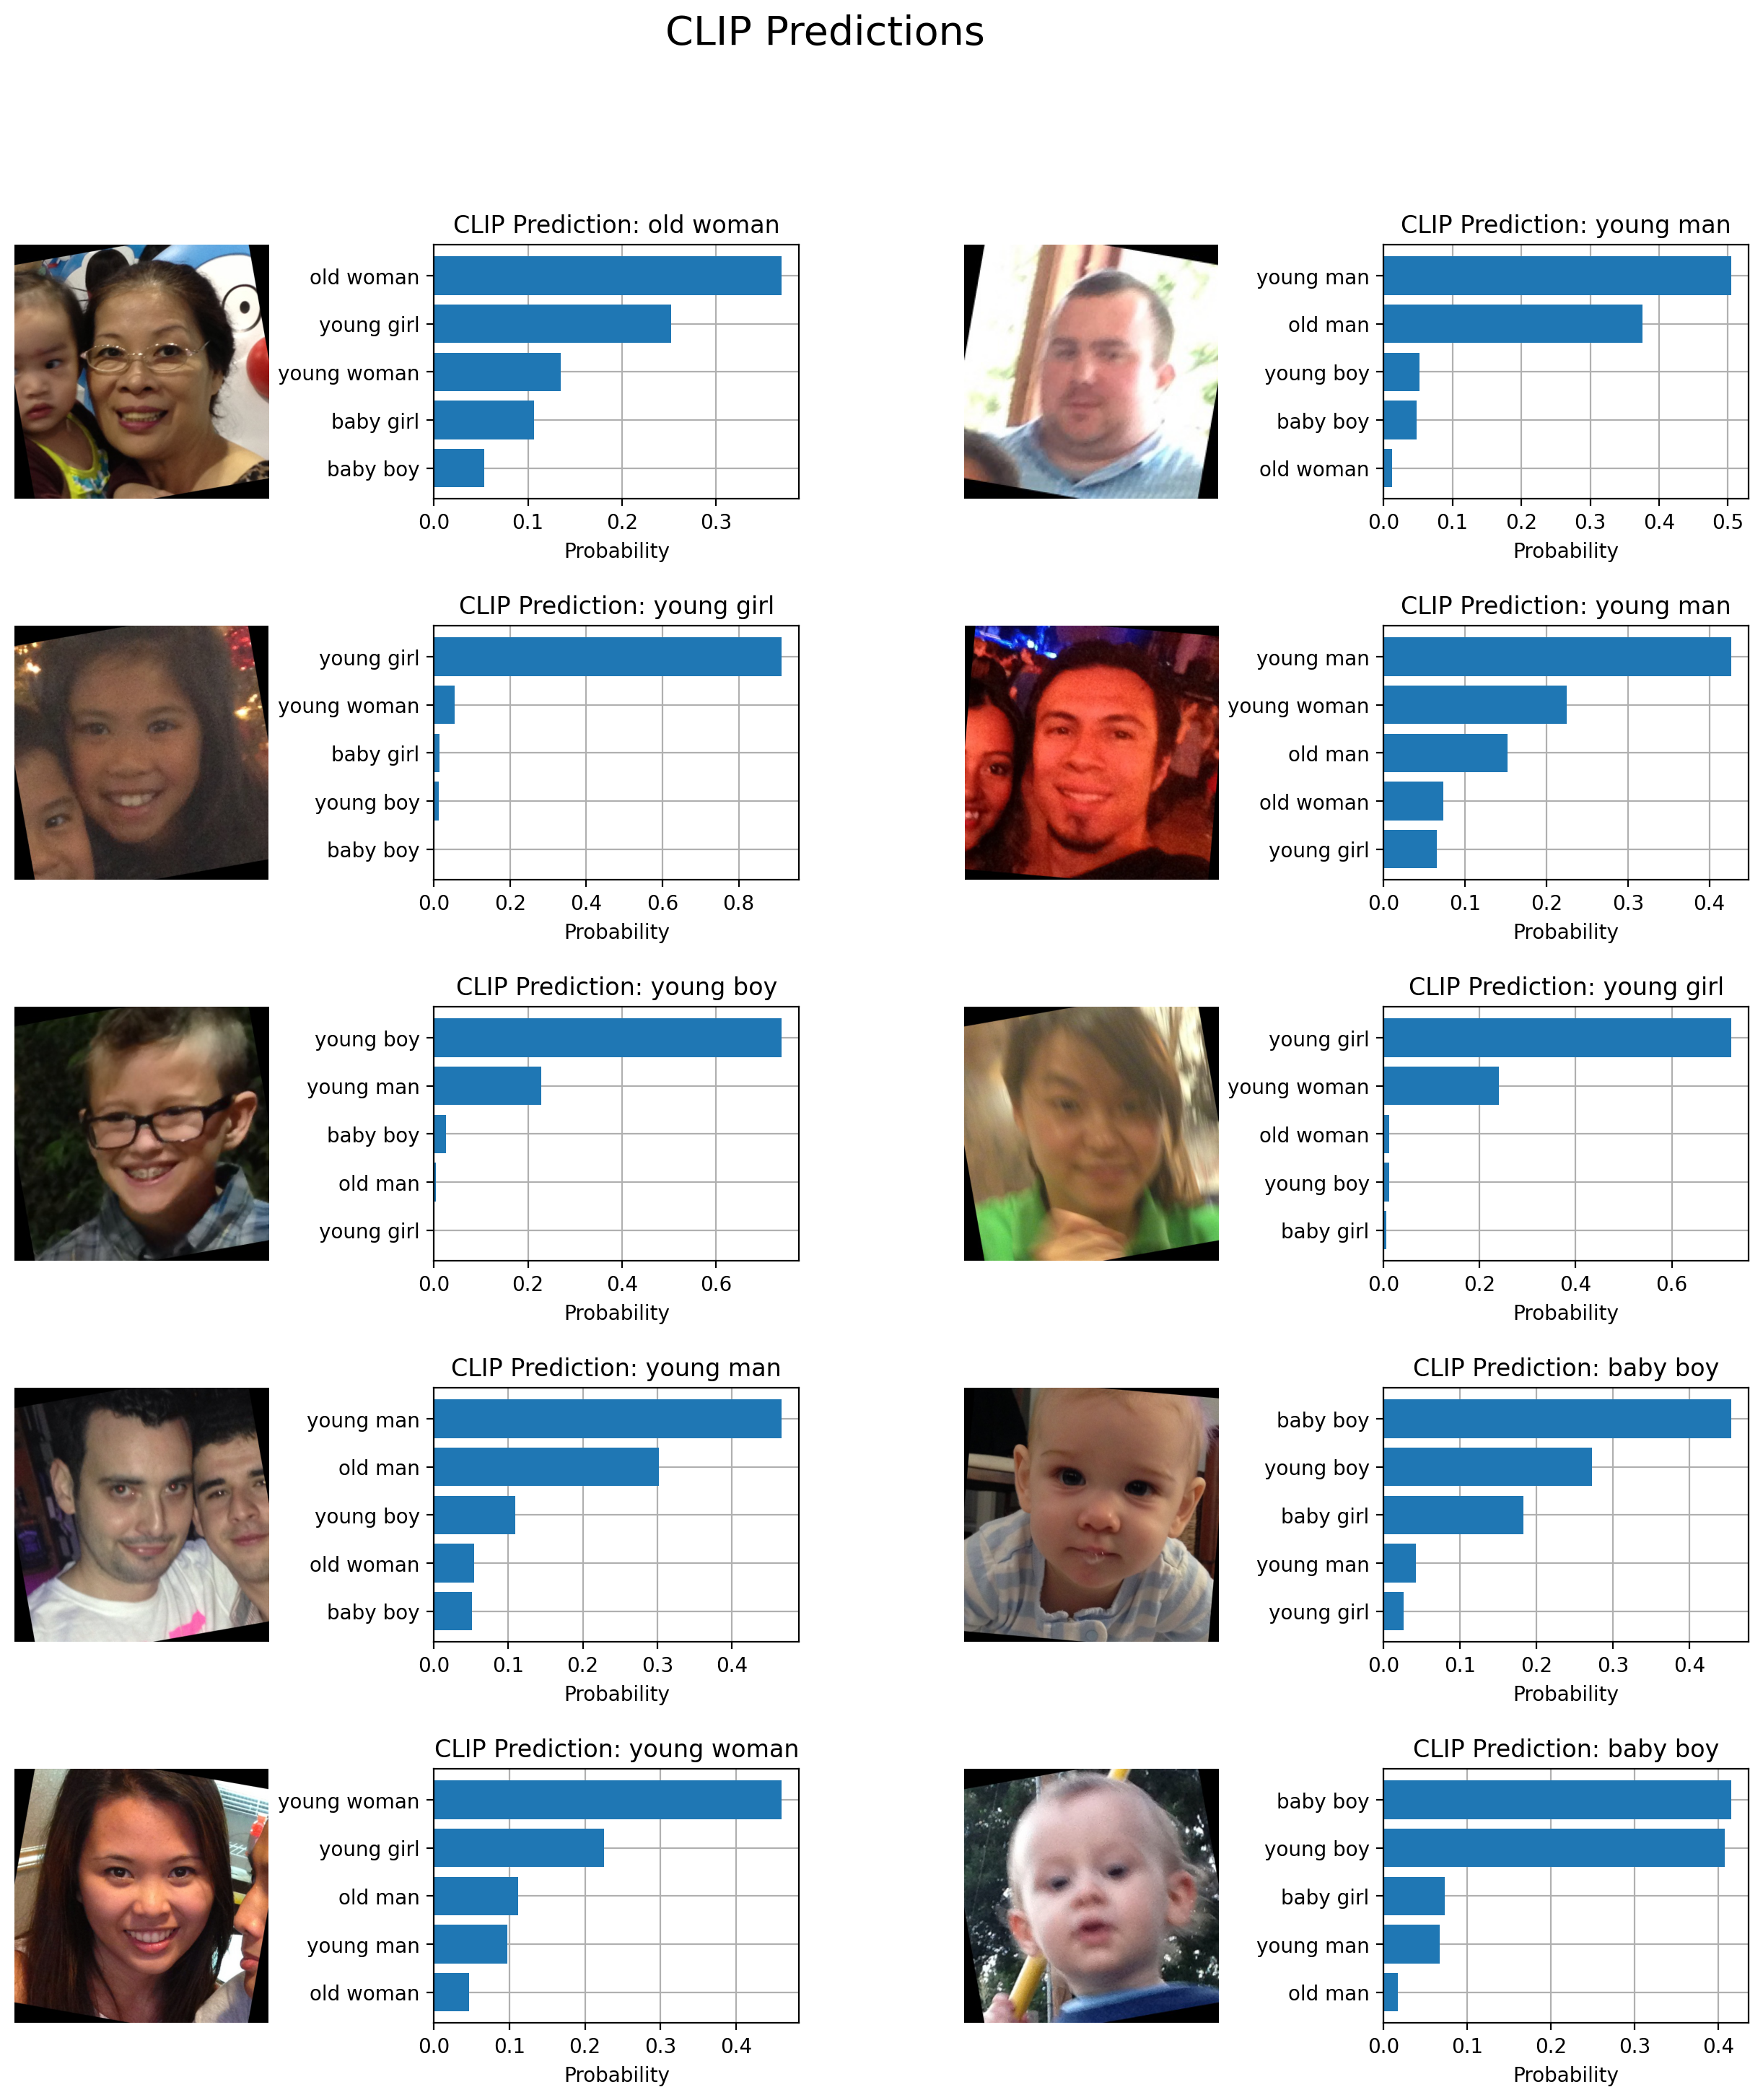

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming original_images is a list or array containing your images
num_images = len(original_images)
random_indices = np.random.choice(num_images, size=10, replace=False)
classes = ["baby girl", "baby boy", "young girl", "young boy",
           "young woman", "young man", "old woman", "old man"]
plt.figure(figsize=(16, 16))
plt.suptitle("CLIP Predictions", fontsize=20)  # Add a title

for i, index in enumerate(random_indices):
    image = original_images[index]
    plt.subplot(5, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(5, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[index])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classes[index] for index in top_labels[index].numpy()])
    plt.xlabel("Probability")

    # Use CLIP predictions as text labels
    plt.title(f"CLIP Prediction: {classes[top_labels[index][0]]}")

plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between subplots
plt.show() 

plt.figure(figsize=(16, 16))



     

We plot some observations, we can observe some really good results in terms of age and in terms of gender.